# Modified MNIST classification challenge - Resnet50

Instead of building our own model from scratch, we will use a state-of-the-art model to 

## 1. Imports 

In [1]:
# Mount the google drive for the dataset 
from google.colab import drive
drive.mount('/content/drive') 
"""
4/sgHaKtMTGqfhccKVyUf1I2jMOFAEczj9b_gBKi5A2BHfDbtr-alpuPM
"""

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'\n4/sgHaKtMTGqfhccKVyUf1I2jMOFAEczj9b_gBKi5A2BHfDbtr-alpuPM\n'

In [2]:

from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

keras = tf.keras


import os
import cv2
import time
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline


from glob import glob
from PIL import Image
from tqdm import tqdm_notebook
from IPython.display import Image
from resnets_utils import *
from sklearn.utils import shuffle
from sklearn.datasets import load_files   
from sklearn.model_selection import train_test_split 
from urllib.request import urlopen,urlretrieve


from tensorflow.keras import optimizers
from tensorflow.keras import applications
from tensorflow.keras.models import load_model

from keras.utils import np_utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.models import Sequential,Model,load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,GlobalAveragePooling2D
from tensorflow.keras.callbacks import TensorBoard,ReduceLROnPlateau,ModelCheckpoint

print(tf.test.is_built_with_cuda())
print(tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)) 


TensorFlow 2.x selected.
True
True


Using TensorFlow backend.


## 2. Loading and pre-processing the dataset 

### 2.1 Load the data

In [3]:
## Read train and test images. NOTE: This is a bit slow.
t0 = time.time()
train_images = pd.read_pickle('./drive/My Drive/Colab Notebooks/Data/train_max_x') 
test_images = pd.read_pickle('./drive/My Drive/Colab Notebooks/Data/test_max_x')
train_labels = pd.read_csv("./drive/My Drive/Colab Notebooks/Data/train_max_y.csv").iloc[:,1]
LABELS= sorted(set(train_labels))
t1 = time.time()
print("Done in {} seconds".format(t1-t0))

# print(os.getcwd())
# files = [f for f in os.listdir('.') if os.path.isfile(f)]
# print(files)

Done in 11.570643901824951 seconds


In [4]:
print(train_labels.head(10))

0    6
1    7
2    2
3    9
4    7
5    8
6    7
7    6
8    8
9    8
Name: Label, dtype: int64


We can now see a couple of samples

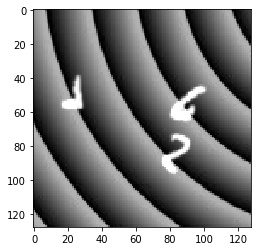

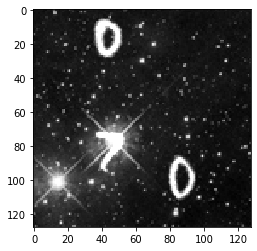

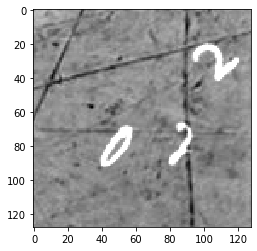

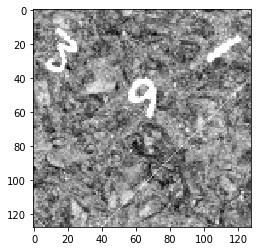

In [5]:
for i in range(4): 
    plt.figure()
    plt.imshow(train_images[i], cmap='gray')

Note the shapes of our datasets, and examine the labels as well. 



In [6]:
# Examine the shapes of our data 
print("Shape of training set: ", train_images.shape) 
print("Shape of test set: ", test_images.shape) 
print("Shape of our labels: ", train_labels.shape) 
print("Unique labels: ", LABELS)


Shape of training set:  (50000, 128, 128)
Shape of test set:  (10000, 128, 128)
Shape of our labels:  (50000,)
Unique labels:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


### 2.3 Data Preprocessing 

Although some preprocessing work has already been done on these images, we still need to do a couple of things. 

1. We will reshape the data to a format tha the model can understand: (num_datapoints, dim1, dim2, channel)
2. We will further split the dataset in order to have some validation . This will also randomize the data. 
3. We will normalize the data to have values between 0 and 1. This will make a huge impact weh training. 

In [33]:
# Reshaping the images  
train_images = np.reshape( train_images, (50000, 128, 128, 1)) 
test_images = np.reshape( test_images, (10000, 128, 128, 1)) 
print("Shape of training set: ", train_images.shape) 
print("Shape of test set: ", test_images.shape) 


Shape of training set:  (50000, 128, 128, 1)
Shape of test set:  (10000, 128, 128, 1)


In [8]:
# further split into training and testing data
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(train_images, train_labels, 
                                                                    test_size=.1, # CHANGE: BEFORE 0.1
                                                                    random_state=42)

# normalize images 
X_train_new = X_train_new / 255.0 
X_test_new = X_test_new / 255.0

# convert data to tensors 
X_train_new = tf.convert_to_tensor(X_train_new, dtype=tf.float32)
X_test_new = tf.convert_to_tensor(X_test_new, dtype=tf.float32)
y_train_new = tf.keras.utils.to_categorical(y_train_new, num_classes=10)
y_test_new = tf.keras.utils.to_categorical(y_test_new, num_classes=10)

print("Shape of X_train_new {}".format(X_train_new.shape))
print("Shape of X_test_new {}".format(X_test_new.shape))


Shape of X_train_new (45000, 128, 128, 1)
Shape of X_test_new (5000, 128, 128, 1)


In [9]:
# Note that the classes have been one-ncoded to categorical
print(y_train_new[0])

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


## 3. Loading the model: Resnet50V2

Instead of building our own model from scratch, we will rely on state-of-the-art architectures and adpat our problem. This time, our model of choice is RestNet50, whose architecture is shown below. 

(source: https://www.researchgate.net/publication/331364877_Optimized_Deep_Convolutional_Neural_Networks_for_Identification_of_Macular_Diseases_from_Optical_Coherence_Tomography_Images) 

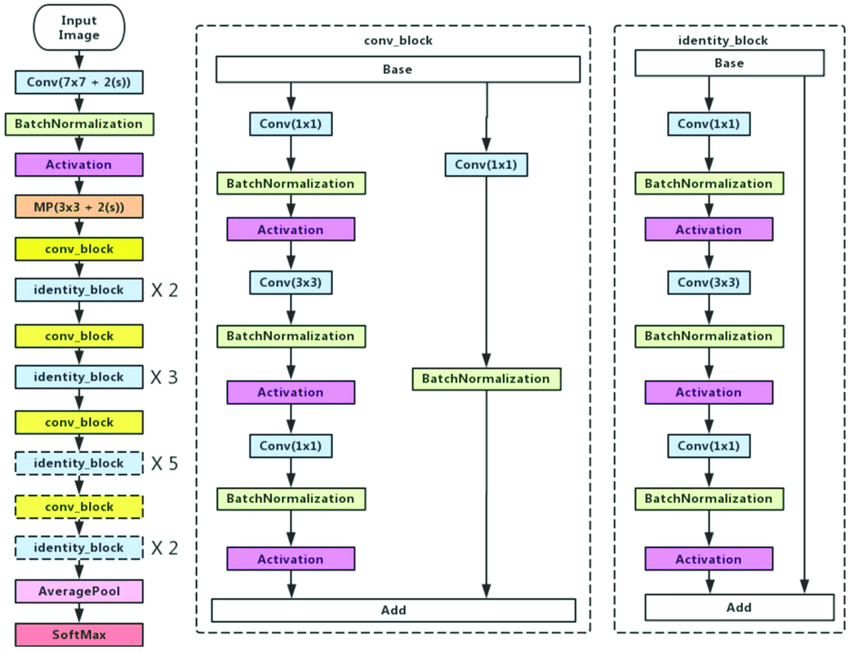

In [10]:
Image('Left-ResNet50-architecture-Blocks-with-dotted-line-represents-modules-that-might-be.png')


Now, we will do the following: 
1. Load the ResNet50V2 pre-trained model. 
2. We will either train the model parameters from scratch, or we can freeze them and then apply transfer learning. This will affect the way we input the data: if the input data only contains one colour channel , i.e. grayscale, then each image will have dimensions (dim1, dim2, 1), where 1 is the grayscale colour channel. Else if we apply transfer learning(i.e., using pre-trained parameters), this number will be 3, in which case we have to modify the input images to fit them in the model. 
3. We will take the model output, add a `GlobalAveragePooling2D` layer, a `Dropout` layer and finally a `Dense` layer with the number of classes equal to 10 in this case, and a `softmax` activation. 
4. Then, we compile the model with an optimizer that could be either `Adam` or `SGD`. 
5. Finally, we train the model with our training and validation sets for X epochs, using small batches of size 32. 



In [0]:
# obtain respective dimensions 
img_height, img_width = train_images.shape[1], train_images.shape[2] 
num_classes = 10  

# load the base model with no pre-trained parameters
base_model = applications.resnet_v2.ResNet50V2(weights=None,  # no pre-trained parameters
                                               include_top=False,  # don't include the top classification layer 
                                           input_shape=(img_height, img_width, 1)) # input dimensions, the "1" 

**Note**: Messing up with the "Dropout" parameter affects convergence speed hugely, but also affect performance. 
Some experimentation has lead us to choose 0.6 this time. 

In [12]:
x = base_model.output 
x = GlobalAveragePooling2D()(x) 
x = Dropout(0.6)(x) # latest parameter update
predictions = Dense(num_classes, activation='softmax')(x) 
model = Model(inputs = base_model.input, outputs= predictions)

In [13]:
from keras.optimizers import SGD, Adam
# sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(optimizer= adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary() 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   3200        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 66, 66, 64)   0           conv1_conv[0][0]                 
______________________________________________________________________________________________

In [14]:
# Obtain the loss and accuracy before training : These metrics should be very bad

evaluation = model.evaluate(X_test_new, y_test_new)
print ("Loss = " + str(evaluation[0]))
print ("Test Accuracy = " + str(evaluation[1]))

5000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [15]:
# First training pass
history = model.fit(X_train_new, y_train_new, 
                    validation_data=(X_test_new, y_test_new), 
                    epochs = 14, batch_size = 32)



Train on 45000 samples, validate on 5000 samples
Epoch 1/14
45000/45000 [==============================] - 376s 8ms/sample - loss: 1.4153 - accuracy: 0.5066 - val_loss: 5.6968 - val_accuracy: 0.4030
Epoch 2/14
45000/45000 [==============================] - 366s 8ms/sample - loss: 0.5866 - accuracy: 0.8163 - val_loss: 0.7022 - val_accuracy: 0.7928
Epoch 3/14
45000/45000 [==============================] - 366s 8ms/sample - loss: 0.3974 - accuracy: 0.8847 - val_loss: 0.5986 - val_accuracy: 0.8396
Epoch 4/14
45000/45000 [==============================] - 365s 8ms/sample - loss: 0.3141 - accuracy: 0.9131 - val_loss: 0.5052 - val_accuracy: 0.8718
Epoch 5/14
45000/45000 [==============================] - 365s 8ms/sample - loss: 0.2604 - accuracy: 0.9289 - val_loss: 0.4742 - val_accuracy: 0.8640
Epoch 6/14
45000/45000 [==============================] - 366s 8ms/sample - loss: 0.2191 - accuracy: 0.9412 - val_loss: 0.4159 - val_accuracy: 0.8822
Epoch 7/14
45000/45000 [===========================

In [0]:
# # # Second training pass: only activate if want to distribute training 
# history2 = model.fit(X_train_new, y_train_new, 
#                     validation_data=(X_test_new, y_test_new), 
#                     epochs = 2, batch_size = 128)

？？？



## 3.1 Saving and loading the model  

Since training takes a lot of time, it is important to save models if we consider them important enough. We also indicate what's different in the name description. 

In [0]:
# Saving the model 
model.save('Modified_MNIST_keras_resnet_14epochs_dropout0.6_full_set2.h5') 

# # Loading the model 
# model = load_model('Modified_MNIST_keras_resnet_10epochs_dropout0.2.h5')

## 4. Evaluating the model 

In [28]:
evaluation = model.evaluate(X_test_new, y_test_new)
print ("Loss = " + str(evaluation[0]))
print ("Test Accuracy = " + str(evaluation[1]))

5000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

## 4.1 Visualizing the metrics 

In order to see how our model behaves over time, we visualize botht the training and validation accuracy and loss over epochs time. 

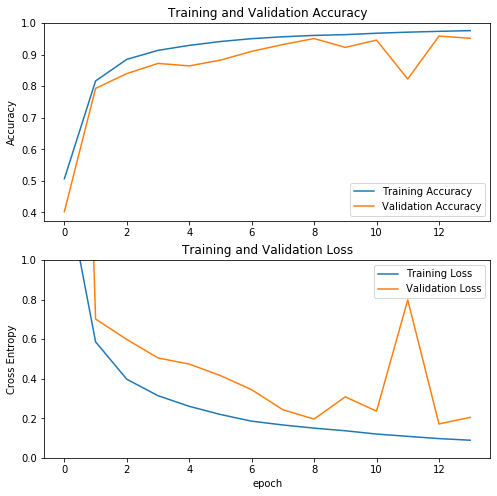

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig('metrics_Modified_MNIST_keras_resnet_12epochs_dropout0.6.png')
plt.show()

## 5. Getting the Predictions 

Now that we have obtained a respectable model,  we are ready to output and export the predictions , which we will then submit on Kaggle. 

In [0]:
# We have to perform the same kind of transformations 
real_X_test = test_images / 255.0
real_X_test = tf.convert_to_tensor(test_images, dtype=tf.float32)
preds = model.predict(real_X_test)

Let's first check out a couple of predictions on the validation set! 

(10000, 128, 128, 1)
Prediction:  8
Prediction:  2
Prediction:  4
Prediction:  5
Prediction:  8


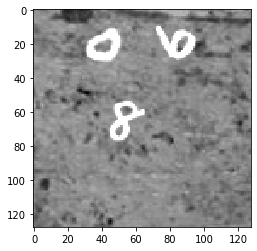

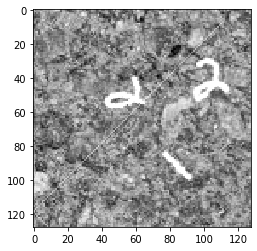

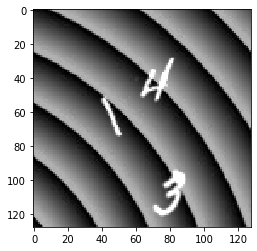

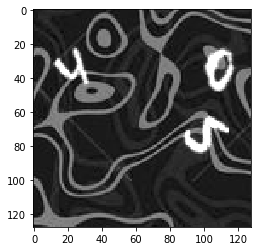

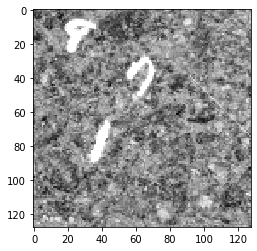

In [35]:
print(test_images.shape)
# Have to put the dimensions back as they were  
test_images = np.reshape(test_images, (10000,128,128))


for i in range(5,10): 
    plt.figure()
    plt.imshow(test_images[i], cmap='gray')
    print("Prediction: ", np.argmax(preds[i]))

Now we will convert this to a list of predictions , and then  download. 

In [36]:
predictions =  [np.argmax(pred) for pred in preds ]
ids = range(0,10000)
predictions = pd.DataFrame(zip(ids,predictions), columns=['Id','Label']) 
print(predictions.head())

   Id  Label
0   0      9
1   1      6
2   2      4
3   3      9
4   4      5


In [0]:
from google.colab import files
predictions.to_csv('predictions_resnet_14epochs_dropout0.6_full_set2.csv', index=False)
files.download('predictions_resnet_14epochs_dropout0.6_full_set2.csv') 

At this point, we can go ahead and save the model for later use.

In [0]:
# files.download('Modified_MNIST_keras_resnet_11plus1epochs_dropout0.6.h5')